#### $\S$ 1. Постановка задачи

Под изображением будем понимать вектор $f\in \mathbf{R}^s$. Целью будет нахождение неизвестного изображения $u\in \mathbf{R}^s$ по наблюдаемому изображению $f$. Пусть $\Omega = \{1,2,\dots, s\}$ и $\Lambda \subset \Omega$. Наблюдаемое изображение имеет вид:

$$
f_i = \begin{cases}u_i + \eta_i,~~~i\in\Lambda;\\ \text{проивольно}, ~~~ i\in \Omega\setminus \Lambda.\end{cases}
$$

Задача восстановления неизвестного изображения $u$ относится к задаче аппроксимации. Обозначим $\mathrm{P}_{\Lambda}$ диагональную матрицу, у которой $(\mathrm{P}_{\Lambda})_{i,i} = 1,~~\forall i\in \Lambda$ и $(\mathrm{P}_{\Lambda})_{i,i} = 0,~~\forall i\in \Omega\setminus\Lambda$. Кроме того, введем еще следующие обозначения: $W:~f\to Wf$ -- параметрическое дискретное вейвлет-преобразование, ставящее в соответствие данному изображению $f\in\mathbf{R}^s$ его вейвлет-коэффициенты $Wf\in\mathbf{R}^d$ и $W^{-1}$ -- обратное преобразование. Пусть 

$$
\Gamma_{\lambda}(\beta_1,\dots,\beta_d) = \begin{pmatrix}t_{\lambda_1}(\beta_1) & \dots & t_{\lambda_d}(\beta_d)\end{pmatrix},
$$

где

$$
t_{\lambda_i}(\beta_i) = \begin{cases}\mathrm{sign}(\beta_i)(|\beta_i| - \lambda_i),~~~|\beta_i|>\lambda_i,\\ 0,~~~|\beta_i|\leqslant \lambda_i.\end{cases}
$$

Изображение $u$ будем находить из следующей задачи минимизации:

$$
u = W^{-1} \beta^*;
$$

$$
\beta^* = \min_{\beta\in\mathbf{R}^d} \frac{1}{2}\|\mathbf{P}_{\Lambda}W^{-1}\beta - \mathbf{P}_{\Lambda}f\|_2^2 + \|\mathrm{diag}(\lambda)\beta\|_1.
$$

Как показано в статье [1], решение задачи минимизации

$$
\beta^*(\alpha) = \arg\min_{\beta\in\mathbf{R}^d} \frac{1}{2}\|\mathbf{P}_{\Lambda}W_{\alpha}^{-1}\beta - \mathbf{P}_{\Lambda}f\|_2^2 + \|\mathrm{diag}(\lambda)\beta\|_1
$$

можно найти по следующему алгоритму:

**Алгоритм**

1. Выберем произвольный вектор $\beta_0\in\mathbf{R}^d$

2. Находим $\beta_{k+1} = \Gamma_{\lambda}\left(W\mathrm{P}_{\Lambda}f + \beta_k - W\mathrm{P}_{\Lambda} W^{-1} \beta_k\right)$, $k=0,1,\dots$

В статье  [1] доказано, что существует $\beta^* = \lim\limits_{k\to +\infty} \beta_k$. Значение этого предела и является решением задачи минимизации. Таким образом, изображение $u$ можно найти, как $ W^{-1} \beta^*$.

#### Литература

1. J.F. Cai, R.H. Chan, and Z. Shen,A framelet-based image inpainting algorithm, Applied and Computational Harmonic Analysis24(2008), no. 2, 131–149.

In [1]:
import numpy as np
import pandas as pd
import torch
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class CWaveletAnalis():
    ''' Класс, в котором реализуются алгоритмы вейвлет-разложения и
        восстановления. Здесь I -- данное изображение из V_j
    '''
    def __init__(self, I, j):
        self.I = I
        self.j = j
        self.filters = {'u': self.Mask_u(), 'v': self.Mask_v()}
        self.tilde_K = self.filters['u'].index[-1]
        
        self.W, self.c_l_columns, self.d_columns, self.c_l_index, self.d_index = self.Decomposition_I(I)
        
        ''' Подготовка фильтров для восстановления ...'''

        self.K = self.filters['u'].index[-1]
        self.ker_u = np.flip(self.filters['u'].values).reshape((1, 1, -1))
        self.ker_v = np.flip(self.filters['v'].values).reshape((1, 1, -1))
        for i in range(np.max(self.W.shape) - 1):
            self.ker_u = np.concatenate([self.ker_u, np.flip(self.filters['u'].values).reshape((1, 1, -1))], 0)
            self.ker_v = np.concatenate([self.ker_v, np.flip(self.filters['v'].values).reshape((1, 1, -1))], 0)
    
    #---------------------Фильтры----------------------------------------------
    def Mask_u(self):
        '''
        Маска масштабирующей функции \varphi
        '''
        u = pd.Series(0, index = range(-3, 4, 1))
        u.loc[3] = (1.0 + np.sqrt(3.0)) / (4.0 * np.sqrt(2.0))
        u.loc[2] = (3.0 + np.sqrt(3.0)) / (4.0 * np.sqrt(2.0))
        u.loc[1] = (3.0 - np.sqrt(3.0)) / (4.0 * np.sqrt(2.0))
        u.loc[0] = (1.0 - np.sqrt(3.0)) / (4.0 * np.sqrt(2.0))
        u.loc[-1] = 0
        u.loc[-2] = 0
        u.loc[-3] = 0
        return u

    def Mask_v(self):
        '''
        Маска материнского вейвлета \psi
        '''
        u = self.Mask_u()
        v = pd.Series(0, index = range(-3, 4, 1)) # делаем одного размера
        for n in v.index:
            if (1 - n in u.index):
                v.loc[n] = ((-1) ** (n - 1)) * u.loc[1 - n]
        return v

    def Reconstruction_2D_torch(self, ker_u, ker_v, W, c_columns, d_columns, K):
        # Вейвлет-восстановление строк матрицы
        # носитель последовательностей u, v равен [-K;K]
        q_0 = c_columns[0]
        q_1 = c_columns[-1]
        c_l = pd.DataFrame(W[:, :(q_1 - q_0 + 1)], index = range(W.shape[0]), columns = range(q_0, q_1 + 1, 1))
        p = q_1 - q_0 + 1
        
        for key in d_columns.keys():
            k_0 = d_columns[key][0]
            k_1 = d_columns[key][-1]
            D = W[:, p:(p + k_1 - k_0 + 1)]
            p += k_1 - k_0 + 1
            
            c_l = c_l.loc[:, k_0:k_1].values
            c = np.zeros((W.shape[0], 2 * k_1 - 2 * k_0 + 1), dtype = np.float64)
            c[:, ::2] = c_l[:, :]
            c = np.concatenate([np.zeros((W.shape[0], K)), c, np.zeros((W.shape[0], K))], axis = 1)
            c = c.reshape((1, W.shape[0], -1))
            
            d = np.zeros((W.shape[0], 2 * k_1 - 2 * k_0 + 1), dtype = np.float64)
            d[:, ::2] = D[:, :]
            d = np.concatenate([np.zeros((W.shape[0], K)), d, np.zeros((W.shape[0], K))], axis = 1)
            d = d.reshape((1, W.shape[0], -1))
            
            c_l = torch.nn.functional.conv1d(torch.tensor(c), torch.tensor(ker_u), padding = 'same', groups = W.shape[0])[0, :, :]
            c_l += torch.nn.functional.conv1d(torch.tensor(d), torch.tensor(ker_v), padding = 'same', groups = W.shape[0])[0, :, :]
            q_0 = 2 * k_0 - K
            q_1 = 2 * k_1 + K
            
            c_l = pd.DataFrame(c_l.numpy(), index = range(W.shape[0]), columns = range(q_0, q_1 + 1, 1))
        
        return c_l
    
    def Reconstruction_I(self, W):
        '''
        Вейвлет-восстановление изображения по вейвлет-коэффициентам
        '''
        J = self.Reconstruction_2D_torch(self.ker_u[:self.W.shape[1], :, :],
                                         self.ker_v[:self.W.shape[1], :, :],
                                         W.T, self.c_l_index, self.d_index, self.K)
        J_index = J.columns
        J = J.values.T
        
        if (J.shape[0] > self.ker_u.shape[0]):
            for i in range(self.ker_u.shape[0], J.shape[0], 1):
                self.ker_u = np.concatenate([self.ker_u, np.flip(self.filters['u'].values).reshape((1, 1, -1))], 0)
                self.ker_v = np.concatenate([self.ker_v, np.flip(self.filters['v'].values).reshape((1, 1, -1))], 0)
            
        J = self.Reconstruction_2D_torch(self.ker_u[:J.shape[0], :, :],
                                         self.ker_v[:J.shape[0], :, :],
                                         J, self.c_l_columns, self.d_columns, self.K)
        J_columns = J.columns
        J = pd.DataFrame(J.values, index = J_index, columns = J_columns)
        J = J.loc[0:(self.I.shape[0] - 1), 0:(self.I.shape[1] - 1)].values
        return J
    
    def Decomposition_2D_torch(self, A, ker_u, ker_v):
        '''
        Вейвлет-разложение строк матрицы
        '''
        q_1 = 0
        d_columns = {}
        c = A
        for key in range(-1, -abs(self.j) - 1, -1):
            c = np.concatenate([np.zeros((A.shape[0], self.tilde_K)), c, np.zeros((A.shape[0], self.tilde_K))], axis = 1) # Добавляем нули слева и справа
            c = c.reshape((1, c.shape[0], -1))
            d = torch.nn.functional.conv1d(torch.tensor(c), torch.tensor(ker_v), padding = 'same', groups = A.shape[0])[0, :, :]
            c = torch.nn.functional.conv1d(torch.tensor(c), torch.tensor(ker_u), padding = 'same', groups = A.shape[0])[0, :, :]
            if ((q_1 - self.tilde_K) % 2 == 0):
                k0 = np.int64((q_1 - self.tilde_K) / 2)
                i0 = 0
            else:
                if (q_1 - self.tilde_K < 0):
                    k0 = np.int64((q_1 - self.tilde_K) / 2)
                else:
                    k0 = np.int64((q_1 - self.tilde_K) / 2) + 1
                i0 = 1
            c = c[:, i0::2]
            d = d[:, i0::2]
            k1 = k0 + c.shape[1] - 1
            c_columns = range(k0, k1 + 1, 1)
            d_columns[key] = range(k0, k1 + 1, 1)
            if (key == -1):
                R = d
            else:
                R = np.concatenate([d, R], axis = 1)
            q_1 = k0
        R = np.concatenate([c, R], axis = 1)
        return [R, c_columns, dict(reversed(d_columns.items()))]
    
    def Decomposition_I(self, I):
        '''
        Вейвлет-разложение изображения
        '''
        ker_u = self.filters['u'].values.reshape((1, 1, -1))
        ker_v = self.filters['v'].values.reshape((1, 1, -1))
        for i in range(I.shape[0] - 1):
            ker_u = np.concatenate([ker_u, self.filters['u'].values.reshape((1, 1, -1))], 0)
            ker_v = np.concatenate([ker_v, self.filters['v'].values.reshape((1, 1, -1))], 0)
        
        R, c_l_columns, d_columns = self.Decomposition_2D_torch(I, ker_u, ker_v)
        
        ker_u = self.filters['u'].values.reshape((1, 1, -1))
        ker_v = self.filters['v'].values.reshape((1, 1, -1))
        for i in range(R.shape[1] - 1):
            ker_u = np.concatenate([ker_u, self.filters['u'].values.reshape((1, 1, -1))], 0)
            ker_v = np.concatenate([ker_v, self.filters['v'].values.reshape((1, 1, -1))], 0)
            
        R, c_l_index, d_index = self.Decomposition_2D_torch(R.T, ker_u, ker_v)
        
        return [R.T, c_l_columns, d_columns, c_l_index, d_index]

#### $\S$ 2. Проверка работы алгоритмов разложения и восстановления

In [3]:
I = np.random.normal(1, 1, size = (17, 15))
wa = CWaveletAnalis(I, 3)
J = wa.Reconstruction_I(wa.W)
print(np.max(np.abs(I - J)))

6.217248937900877e-15


(320, 251)


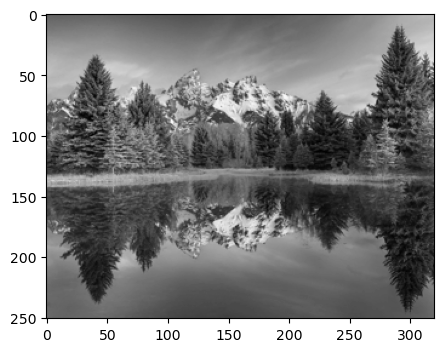

In [4]:
f = Image.open('im_7.jpg').convert('L')
h, w = f.size
f = f.resize((np.int64(h / 6), np.int64(w / 6)))
fig = plt.figure(figsize = (5,5))
plt.imshow(f, cmap='gray')
print(f.size)

In [5]:
f = np.array(f)
f.shape

(251, 320)

In [6]:
''' Здесь создаем то, что будем закрашивать. Удалять будем линии '''
P_Lambda = np.zeros((np.array(f).shape)) + 1
x0 = np.int64(np.array(f).shape[0] / 2)
y0 = np.int64(np.array(f).shape[1] / 2)
N = 1000
for i in range(N):
    x = np.int64(x0 + 100 * ((np.cos(2 * np.pi * i / N)) ** 3))
    y = np.int64(y0 + 100 * ((np.sin(2 * np.pi * i / N)) ** 3))
    P_Lambda[x-2:x, y-2:y] = 0

(251, 320)


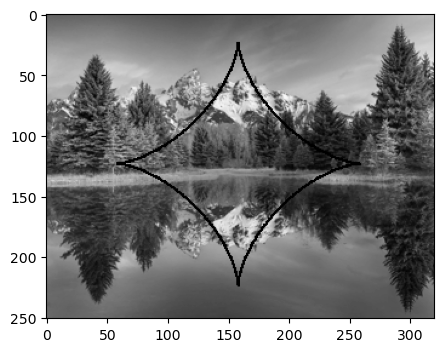

In [7]:
Pf = P_Lambda * np.array(f)
fig = plt.figure(figsize = (5,5))
plt.imshow(Pf, cmap='gray')
print(Pf.shape)

#### $\S$ 3. Реализация алгоритма подрисовки

In [8]:
def Gamma(A, lamb):
    B = np.abs(A) - lamb
    B[np.nonzero(B <= 0)] = 0
    B = np.sign(A) * B
    return B

def optim(wa, beta, Epoch, lamb):
    WPf = wa.W
    for k in range(Epoch):        
        beta_k = beta
        W_1Betta_0 = wa.Reconstruction_I(beta_k)
        mask = P_Lambda*W_1Betta_0
        term2 = wa.Decomposition_I(mask)
        beta = Gamma(WPf + beta_k - term2[0], lamb)
    u = wa.Reconstruction_I(beta)
    return [u, beta_k]

In [9]:
j = 3
wa = CWaveletAnalis(Pf, j)
WPf = wa.W #одна и та же во всех итерациях, в самом начале не меняеться 𝑊PΛ𝑓
beta = wa.W #бетта 0
lamb = np.zeros(WPf.shape) + 1 
u_star, beta = optim(wa, beta, 1000, lamb)

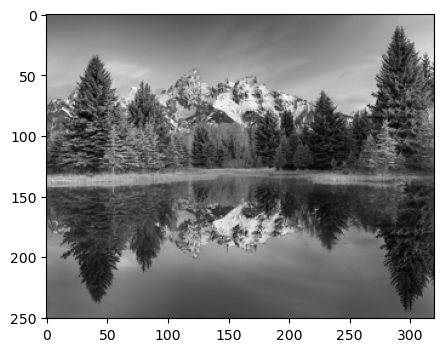

In [10]:
fig = plt.figure(figsize = (5,5))
plt.imshow(u_star, cmap='gray')

#### $\S$ 4. Удаление текста

(420, 262)


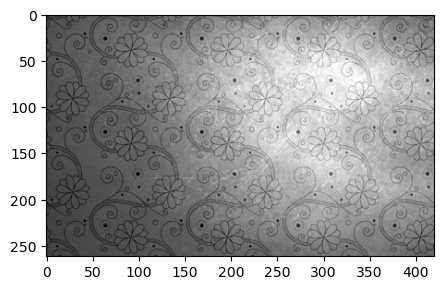

In [11]:
f = Image.open('im6.jpeg').convert('L')
h, w = f.size
f = f.resize((np.int64(h / 4), np.int64(w / 4)))
h, w = f.size
fig = plt.figure(figsize = (5,5))
plt.imshow(f, cmap='gray')
print(f.size)

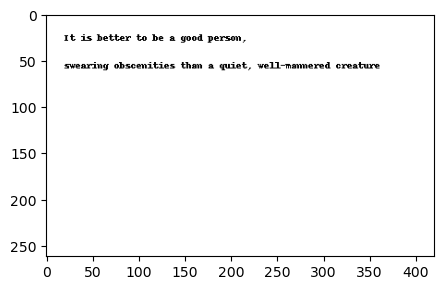

In [12]:
from PIL import ImageDraw
f_text = Image.fromarray(np.zeros((w, h)) + 255)
draw = ImageDraw.Draw(f_text)
draw.text((20, 20), "It is better to be a good person,")
draw.text((20, 50), "swearing obscenities than a quiet, well-mannered creature")
fig = plt.figure(figsize = (5,5))
plt.imshow(f_text, cmap='gray')

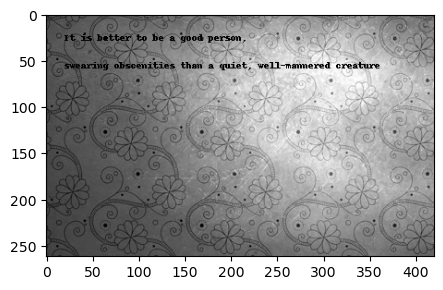

In [13]:
f = np.array(f)
P_Lambda = np.zeros((f.shape)) + 1
T = np.nonzero(np.array(f_text) < 255)
P_Lambda[T] = 0
Pf = P_Lambda * f
fig = plt.figure(figsize = (5,5))
plt.imshow(Pf, cmap='gray')

In [14]:
j = 3
wa = CWaveletAnalis(Pf, j)
WPf = wa.W 
beta = wa.W
lamb = np.zeros(WPf.shape) + 1
u_star, beta = optim(wa, beta, 1000, lamb)

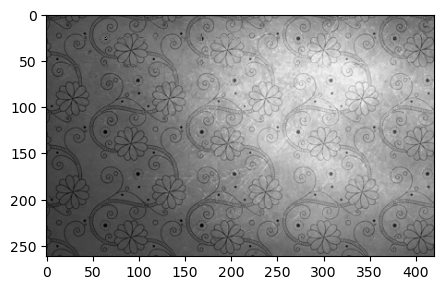

In [15]:
fig = plt.figure(figsize = (5,5))
plt.imshow(u_star, cmap='gray')

## Все работает 

$\underset{\smile}{\overset{\frown}{\bullet}\overset{\frown}{\bullet}}$